In [1]:
from glasspy.predict.models import GlassNet
from glasspy.data import SciGlass, sciglass_dbinfo

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau, zscore
from scipy.constants import pi
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
def get_gs(df, tm = 'Tl', jez=False):
    df['K_W_Tc'] = (df.Tc - df.Tg) / df[tm] # best one in the paper
    df['K_W_Tx'] = (df.Tx - df.Tg) / df[tm]
    df['gamma_Tc'] = df.Tc / (df.Tg+df.Tl)
    df['H_prime_Tx'] = (df.Tx - df.Tg) / df.Tg
    df['K_H_Tc'] = (df.Tc - df.Tg) / (df[tm] - df.Tc) # replaced Tmelt with Tliq
    df['H_prime_Tc'] = (df.Tc - df.Tg) / df.Tg
    df['K_H_Tx'] = (df.Tx - df.Tg) / (df[tm] - df.Tx) # replaced Tmelt with Tliq
    df['deltaT_rg'] = (df.Tx - df.Tg) / (df.Tl - df.Tg)
    df['K_cr'] = (df.Tl - df.Tx) / (df.Tl - df.Tg)
    if jez:
        df['Jezica'] = (df.ViscosityAtTl) - 2 * np.log10(df.Tl)
    return df
    
def get_eta_tl(df):
    return df['log10 (η∞)'] + (12-df['log10 (η∞)'])*(df.T12/df.Tl)*np.exp((df.m/(12-df['log10 (η∞)'])-1)*(df.T12/df.Tl - 1))
    
def get_gfa(df, logXs = -2, logNs = 3, g=pi, Tm = 'Tl', **kw):
    Umax = 10 ** df.log_Umax
    
    tn = (10**logXs / (g * 10**logNs * Umax**2))**(1 / 2)

    df['GFA'] = -np.log10((df[Tm] - df.T_Umax) / tn)
    return df

In [3]:
glassnet_stnn = GlassNet()
glassnet_train_df = glassnet_stnn.get_training_dataset()
glassnet_test_df = glassnet_stnn.get_test_dataset()

In [4]:
X_glassnet_test = glassnet_test_df.elements
X_glassnet_train = glassnet_train_df.elements
X_glassnet_total = pd.concat( (X_glassnet_train, X_glassnet_test) )

In [5]:
X_glassnet_feats_test, feats = glassnet_stnn.featurizer(X_glassnet_test, return_cols = True)
X_glassnet_feats_train, feats = glassnet_stnn.featurizer(X_glassnet_train, return_cols = True)

In [6]:
X_glassnet_feats_test = pd.DataFrame(X_glassnet_feats_test, columns = feats)
X_glassnet_feats_train = pd.DataFrame(X_glassnet_feats_train, columns = feats)

In [7]:
X_glassnet_feats_test.index = X_glassnet_test.index
X_glassnet_feats_train.index = X_glassnet_train.index

In [8]:
y_glassnet_test = glassnet_test_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})
y_glassnet_train = glassnet_train_df.property.rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})
y_glassnet_total = pd.concat( (y_glassnet_train, y_glassnet_test) )

In [10]:
benchmark_df = pd.read_csv('gfa_benchmarks.csv',sep=";") # Table 2
benchmark_df.rename(columns={'Tg (K)': 'Tg', 'Tx (K)': 'Tx', 'Tc (K)': 'Tc', 'Tl (K)': 'Tl', 'T(Umax) (K)': 'T_Umax',
                             'Umax (m s−1)': 'Umax'}, inplace=True)
benchmark_df['log10 (η∞)'] = benchmark_df['log10 (η∞)'].str.replace('−', '-').astype('float')
benchmark_titles_temps = [r'$T_g$', r'$T_x$', r'$T_c$', r'$T_l$', r'$T_{Umax}$', r'$T_{12}$']
benchmark_df['ViscosityAtTl'] = get_eta_tl(benchmark_df)
benchmark_df['log_Umax'] = np.log( benchmark_df.Umax.str.replace('E', 'e').str.replace('−', '-').values.astype(float) )

In [11]:
cols = ['Tg', 'Tc', 'Tx', 'Tl', 'T_Umax', 'log_Umax']
titles = ['$T_g$', '$T_c$', '$T_x$', '$T_l$', '$T_{max(U)}$', '$log(U_{max})$']

In [12]:
myrcparams = {
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'axes.labelcolor': 'black',
    'xtick.labelcolor': 'black',
    'ytick.labelcolor': 'black',
    #'axes.xmargin': 0,
    #'axes.ymargin': 0,
    'legend.fontsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.autolayout': True,
    'figure.figsize': (4.5,4)
}
plt.rcParams.update(myrcparams)

# Property distributions (Figure S1)

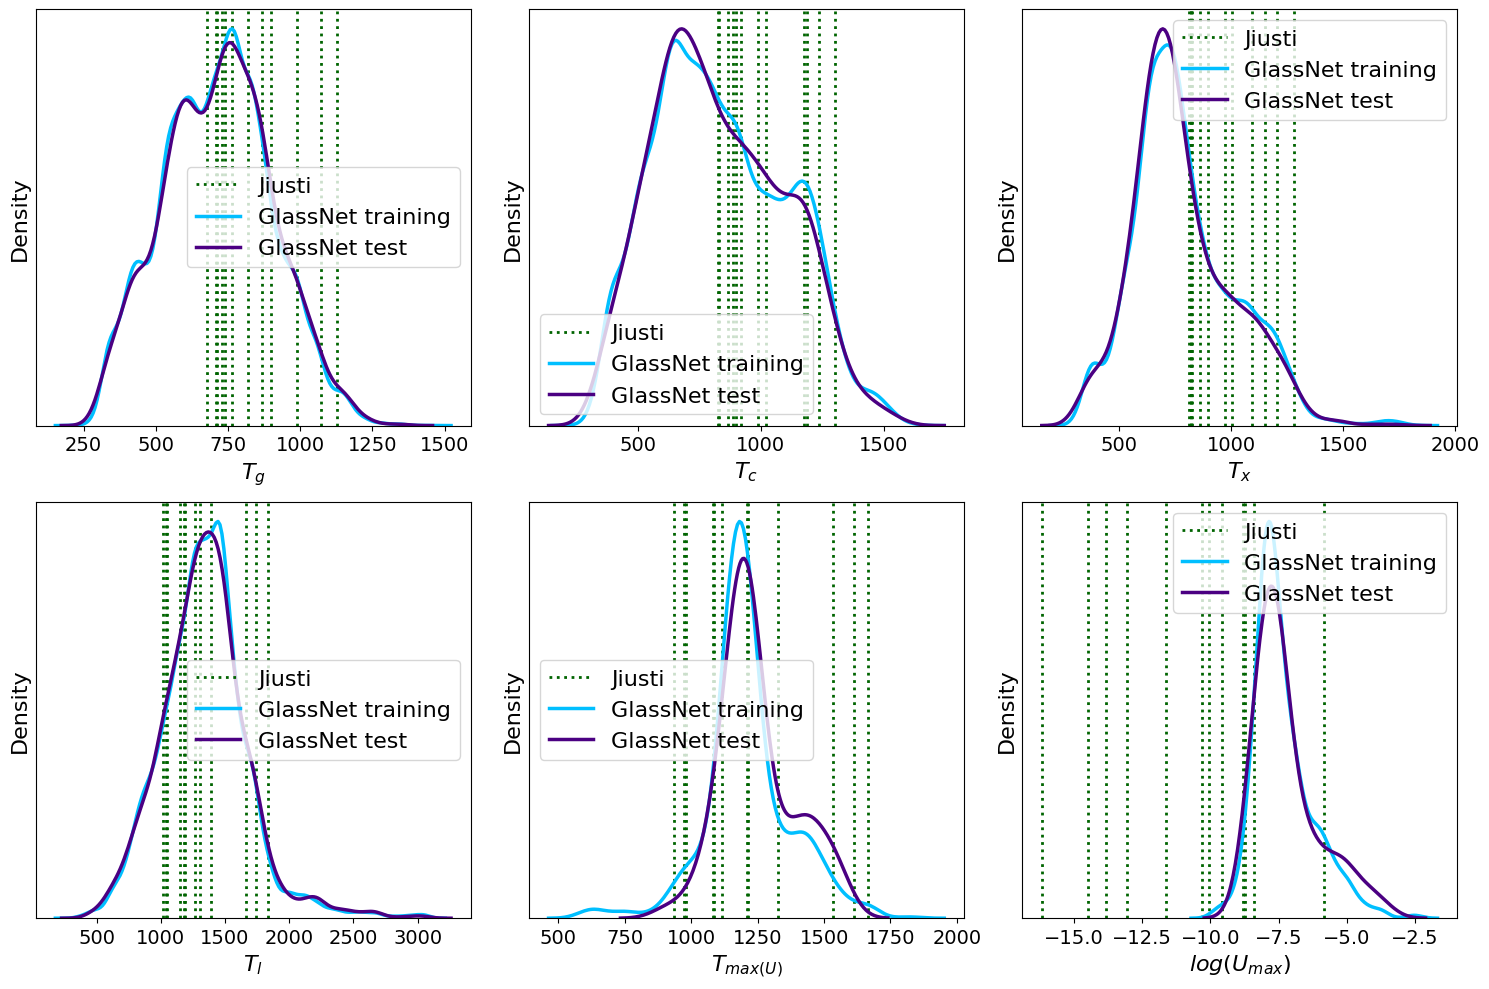

In [13]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
for i,col in enumerate(cols):
    y_train = y_glassnet_train[col].dropna()
    y_test = y_glassnet_test[col].dropna()
    y_benchmark = benchmark_df[col]

    ax = axes[ i // 3, i % 3 ]

    for j,value in enumerate(y_benchmark.values):
        if j == 0:
            ax.axvline( value, color='darkgreen', linestyle='dotted', linewidth=2.0, label='Jiusti' )
        else:
            ax.axvline( value, color='darkgreen', linestyle='dotted', linewidth=2.0 )       
    
    sns.kdeplot( y_train, ax = ax, color='deepskyblue', linewidth=2.5, label = 'GlassNet training' )
    sns.kdeplot( y_test, ax = ax, color='indigo', linewidth=2.5, label = 'GlassNet test'  )
    ax.legend()
    ax.set_xlabel( titles[i] )
    ax.set_yticks([])
    ax.set_yticklabels([])
fig.savefig( 'figures1.png', dpi=600 )

# GlassNet predictions (Figure S2)

In [14]:
benchmark_glassnet_feats =  pd.concat( [ pd.DataFrame( glassnet_stnn.featurizer(comp), columns=feats) for comp in benchmark_df.Glass ] ).reset_index(drop=True)

In [15]:
y_pred_benchmark_stnn = pd.concat( [ glassnet_stnn.predict(comp) for comp in benchmark_df.Glass ] ).reset_index(drop=True).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})

In [16]:
y_pred_glassnet_stnn = glassnet_stnn.predict( X_glassnet_test ).rename(columns={'CrystallizationOnset':'Tx', 'CrystallizationPeak':'Tc', 'TMaxGrowthVelocity': 'T_Umax', 
                           'MaxGrowthVelocity': 'log_Umax', 'Tliquidus':'Tl'})

In [17]:
y_pred_glassnet_stnn.index = y_glassnet_test.index

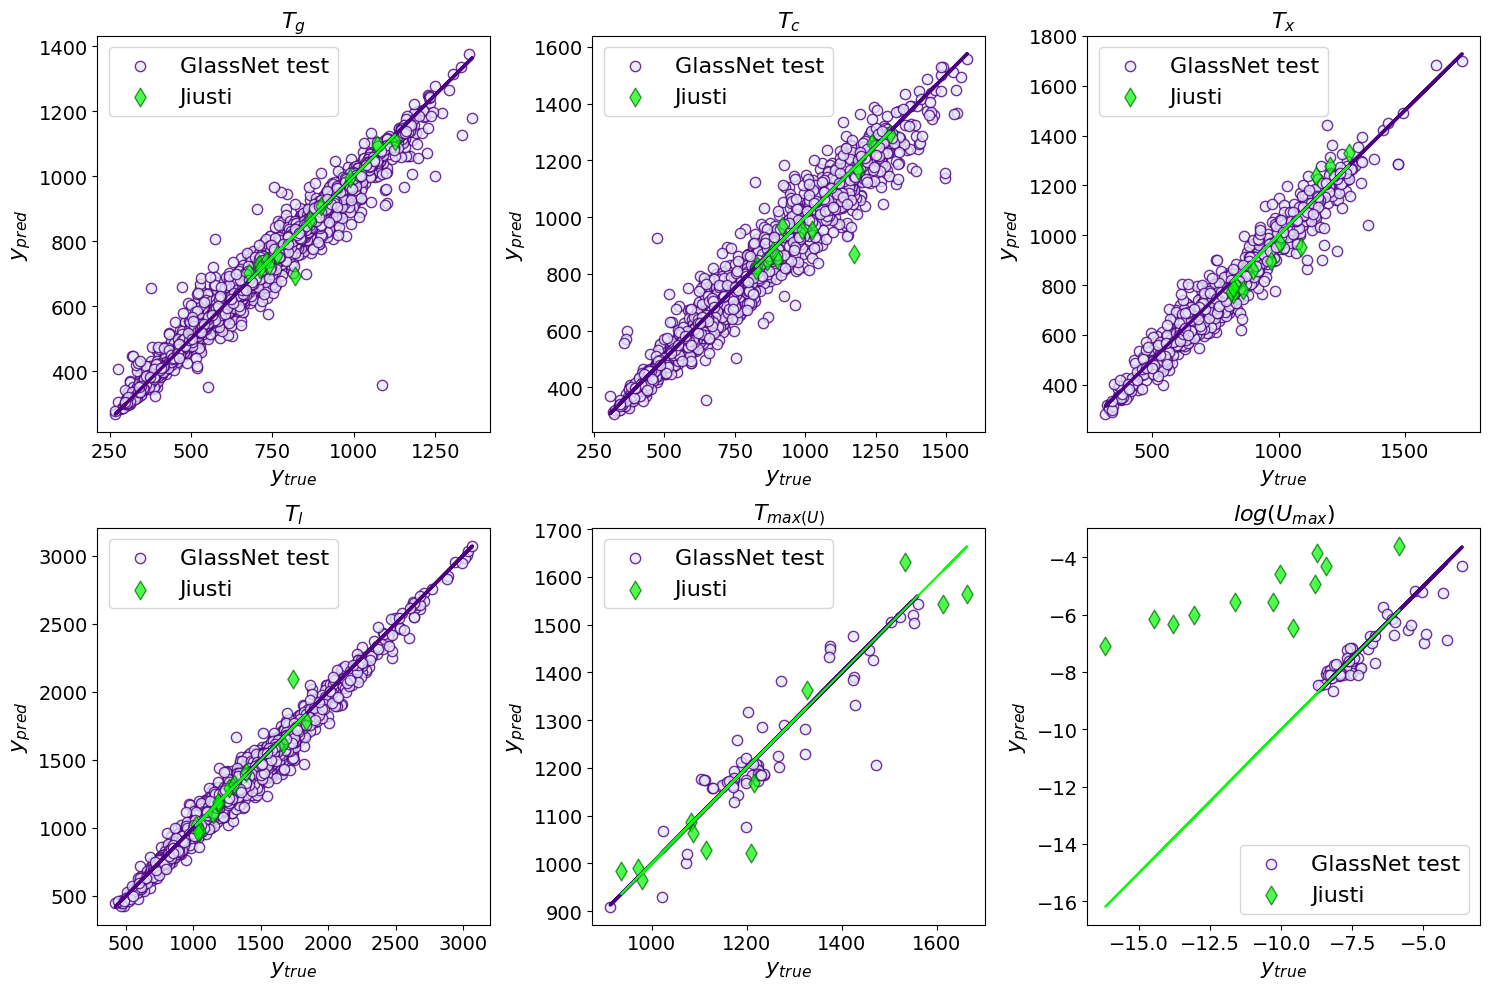

In [18]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(15,10))
for i,col in enumerate(cols):
    this_y_glassnet_true = y_glassnet_test[col].dropna()
    this_y_pred_glassnet = y_pred_glassnet_stnn.loc[this_y_glassnet_true.index, col]
    this_y_benchmark_true = benchmark_df[col]
    this_y_pred_benchmark = y_pred_benchmark_stnn[col]
    ax = axes[ i // 3, i % 3 ]
    ax.scatter(this_y_glassnet_true, this_y_pred_glassnet, marker='o', s=55, alpha=0.8, color='lavender', edgecolor='indigo', label='GlassNet test')
    ax.plot( this_y_glassnet_true, this_y_glassnet_true, color='indigo', linewidth=2.5)
    ax.scatter(this_y_benchmark_true, this_y_pred_benchmark, marker='d', s=90, alpha=0.7, color='lime', edgecolor='darkgreen', label='Jiusti' )
    ax.plot( this_y_benchmark_true, this_y_benchmark_true, color='lime')
    ax.set_xlabel(r'$y_{true}$')
    ax.set_ylabel(r'$y_{pred}$')
    ax.set_title(titles[i])
    ax.legend()
fig.savefig('figures2.png', dpi=600)